In [363]:
from PIL import Image
from pathlib import Path
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [364]:
def vectorizar_imagen(ruta, size):
    img = Image.open(ruta) 
    img = img.convert("RGB").resize((size, size)) # convierte la imagen a RGB y redimensiona la imagen
    img = np.array(img) # convierte a array
    
    r = img[:, :, 0] # matriz r
    g = img[:, :, 1] # matriz g
    b = img[:, :, 2] # matriz b
    gray = 0.299*r + 0.587*g + 0.114*b # forma estándar NTSC para pasar RGB a escala de grises

    vector = gray.flatten() # aplanamos a un vector
    vector = vector / 255.0 # normalizamos
    
    return vector

In [365]:
def inicializar_variables(carpeta_imagenes, size):
    X = [] # guardamos los vectores columna de las imagenes
    y = [] # guardamos las etiquetas reales: 0 si es Healthy y 1 si es Parkinson
    
    for archivo in os.listdir(carpeta_imagenes):
        if archivo.lower().endswith(('.png', '.jpg', '.jpeg')):
            # si tiene parkison, el diagnóstico es positivo (1), sino es negativo (0)
            if archivo.startswith("Healthy"): 
                y.append(0)
            elif archivo.startswith("Parkinson"):
                y.append(1)
        
            # vectorizamos la img en escala de grises
            ruta = os.path.join(carpeta_imagenes, archivo)
            vector_img = vectorizar_imagen(ruta, size)
            X.append(vector_img)
    
    X = np.array(X) # ahora es una matriz
    y = np.array(y) # ahora es un vector
    
    return X, y

In [366]:
X_train, y_train = inicializar_variables("Entrenamiento", size=128)
X_test, y_test = inicializar_variables("Testing", size=128)

In [367]:
def prediccion(X, y, w, b):
    z = X @ w + b
    pred = 1 / (1 + np.exp(-z))
    return pred

In [368]:
def derivadas_logverosimilitud(X, y, w, b):
    pred = prediccion(X, y, w, b)
    error = y - pred

    grad_w = X.T @ error / len(X) # calculamos la media
    grad_b = np.mean(error) # calculamos la media

    return grad_w, grad_b

In [369]:
def actualizacion(X, y, w, b, alpha):
    grad_w, grad_b = derivadas_logverosimilitud(X, y, w, b)

    # Actualización por ASCENSO (se suma)
    w += alpha * grad_w
    b += alpha * grad_b

    return w, b

In [370]:
def logL_accuracy(X, y, w, b):
    pred = prediccion(X, y, w, b)
    # calculamos el logL, agregamos 1e-10 a log por si pred es exactamente 1
    logL = -np.mean(y * np.log(pred + 1e-10) + (1 - y) * np.log(1 - pred + 1e-10)) 
    accuracy = np.mean((pred > 0.5) == (y > 0.5))
    return logL, accuracy

In [371]:
def entrenamiento_ascenso_gradiente(X_train, y_train, X_test, y_test, size=64, alpha=0.0001, repeticiones=1000, epsilon=1e-6):
    w = np.random.randn(X_train.shape[1]) * 0.001 # inicializamos un valor de w random
    b = 0.0 # el b inicial lo dejamos como 0

    print(f"Iniciando entrenamiento con:")
    print(f"  - Tamaño de imagen: {size}")
    print(f"  - Alpha: {alpha}")
    print(f"  - Repeticiones: {repeticiones}\n")
    
    historial_logL_train = []
    historial_accuracy_train = []
    historial_logL_test = []
    historial_accuracy_test = []

    logL_train_anterior = float('inf')

    for i in range(repeticiones):
        logL_accuracy_train = logL_accuracy(X_train, y_train, w, b)
        logL_train_actual = logL_accuracy_train[0]
        historial_logL_train.append(logL_train_actual)
        accuracy_train_actual = logL_accuracy_train[1]
        historial_accuracy_train.append(accuracy_train_actual)
        
        logL_accuracy_test = logL_accuracy(X_test, y_test, w, b)
        logL_test_actual = logL_accuracy_test[0]
        historial_logL_test.append(logL_test_actual)
        accuracy_test_actual = logL_accuracy_test[1]
        historial_accuracy_test.append(accuracy_test_actual)

        w, b = actualizacion(X_train, y_train, w, b, alpha)
        
        if i % 100 == 0 or i == repeticiones - 1:
            print(f"Iteración {i}, LogL Train: {logL_train_actual:.4f}, Accuracy Train: {accuracy_train_actual:.4f} | LogL Test: {logL_test_actual:.4f}, Accuracy Test: {accuracy_test_actual:.4f}")

        if abs(logL_train_actual - logL_train_anterior) < epsilon:
            print(f"Convergencia alcanzada en la iteración {i}") # convergencia -> cortamos
            break

        logL_train_anterior = logL_train_actual
    
    return w, b, historial_logL_train, historial_accuracy_train, historial_logL_test, historial_accuracy_test

In [372]:
size = 64
alpha = 0.0001
repeticiones = 1000

w_final, b_final, logL_train, accuracy_train, logL_test, accuracy_test = entrenamiento_ascenso_gradiente(
    X_train, y_train, X_test, y_test, size, alpha, repeticiones)

Iniciando entrenamiento con:
  - Tamaño de imagen: 64
  - Alpha: 0.0001
  - Repeticiones: 1000

Iteración 0, LogL Train: 0.7005, Accuracy Train: 0.5000 | LogL Test: 0.7008, Accuracy Test: 0.4966
Iteración 100, LogL Train: 0.6930, Accuracy Train: 0.5347 | LogL Test: 0.6928, Accuracy Test: 0.5462
Iteración 200, LogL Train: 0.6926, Accuracy Train: 0.5540 | LogL Test: 0.6924, Accuracy Test: 0.5676
Iteración 300, LogL Train: 0.6922, Accuracy Train: 0.5860 | LogL Test: 0.6920, Accuracy Test: 0.5935
Iteración 400, LogL Train: 0.6918, Accuracy Train: 0.6087 | LogL Test: 0.6917, Accuracy Test: 0.6160
Iteración 500, LogL Train: 0.6914, Accuracy Train: 0.6227 | LogL Test: 0.6913, Accuracy Test: 0.6227
Iteración 600, LogL Train: 0.6910, Accuracy Train: 0.6440 | LogL Test: 0.6910, Accuracy Test: 0.6441
Iteración 700, LogL Train: 0.6906, Accuracy Train: 0.6580 | LogL Test: 0.6906, Accuracy Test: 0.6565
Iteración 800, LogL Train: 0.6903, Accuracy Train: 0.6687 | LogL Test: 0.6903, Accuracy Test: 0.66

In [373]:
def visualizar_entrenamiento(logL_train, accuracy_train, logL_test, accuracy_test):
    plt.figure(figsize=(10, 4))

    # Gráfico del logL
    plt.subplot(1, 2, 1)
    plt.plot(range(len(logL_train)), logL_train, label='LogL Train', color='red')
    if logL_test:
        plt.plot(range(len(logL_test)), logL_test, label='LogL Test', color='orange')
    plt.title('Evolución del LogL')
    plt.xlabel('Iteración')
    plt.ylabel('- LogL')
    plt.grid(True)
    plt.legend()

    # Gráfico del accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(len(accuracy_train)), accuracy_train, label='Accuracy Train', color='green')
    if accuracy_test:
        plt.plot(range(len(accuracy_test)), accuracy_test, label='Accuracy Test', color='blue')
    plt.title('Evolución del Accuracy')
    plt.xlabel('Iteración')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

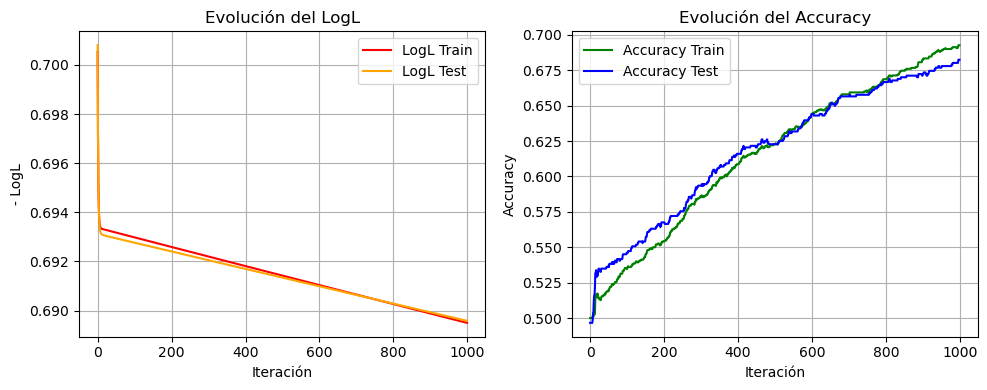

In [374]:
visualizar_entrenamiento(logL_train, accuracy_train, logL_test, accuracy_test)

Iniciando entrenamiento con:
  - Tamaño de imagen: 64
  - Alpha: 0.1
  - Repeticiones: 1000

Iteración 0, LogL Train: 0.6937, Accuracy Train: 0.4993 | LogL Test: 0.6934, Accuracy Test: 0.5023
Convergencia alcanzada en la iteración 25


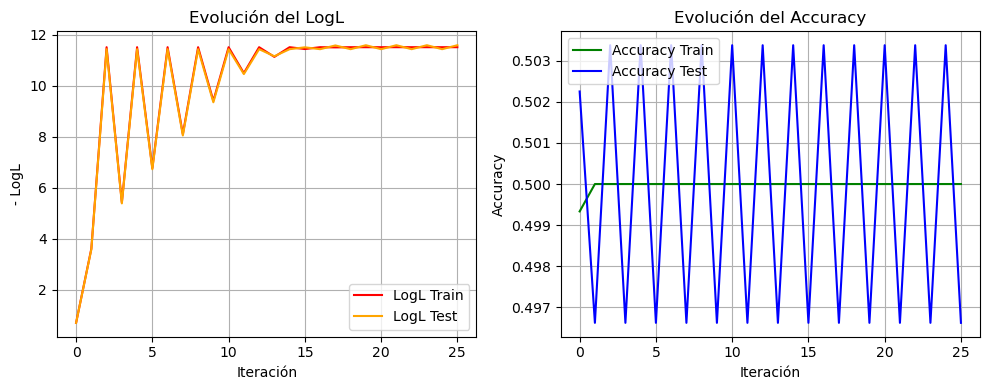

Iniciando entrenamiento con:
  - Tamaño de imagen: 64
  - Alpha: 0.01
  - Repeticiones: 1000

Iteración 0, LogL Train: 0.6938, Accuracy Train: 0.5000 | LogL Test: 0.6938, Accuracy Test: 0.4966
Iteración 100, LogL Train: 11.5129, Accuracy Train: 0.5000 | LogL Test: 11.5907, Accuracy Test: 0.4966
Iteración 200, LogL Train: 11.5129, Accuracy Train: 0.5000 | LogL Test: 11.5907, Accuracy Test: 0.4966
Iteración 300, LogL Train: 11.5129, Accuracy Train: 0.5000 | LogL Test: 11.5907, Accuracy Test: 0.4966
Iteración 400, LogL Train: 11.5129, Accuracy Train: 0.5000 | LogL Test: 11.5907, Accuracy Test: 0.4966
Iteración 500, LogL Train: 11.5129, Accuracy Train: 0.5000 | LogL Test: 11.5907, Accuracy Test: 0.4966
Iteración 600, LogL Train: 11.5129, Accuracy Train: 0.5000 | LogL Test: 11.5907, Accuracy Test: 0.4966
Iteración 700, LogL Train: 11.5129, Accuracy Train: 0.5000 | LogL Test: 11.5907, Accuracy Test: 0.4966
Iteración 800, LogL Train: 11.5129, Accuracy Train: 0.5000 | LogL Test: 11.5907, Accur

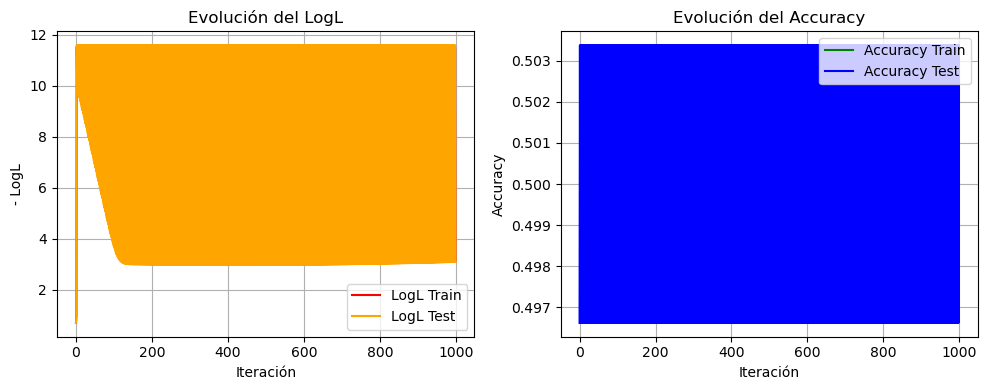

Iniciando entrenamiento con:
  - Tamaño de imagen: 64
  - Alpha: 0.001
  - Repeticiones: 1000

Iteración 0, LogL Train: 0.6930, Accuracy Train: 0.5093 | LogL Test: 0.6930, Accuracy Test: 0.5079
Iteración 100, LogL Train: 1.2204, Accuracy Train: 0.5000 | LogL Test: 1.2015, Accuracy Test: 0.5034
Iteración 200, LogL Train: 1.2166, Accuracy Train: 0.5000 | LogL Test: 1.1979, Accuracy Test: 0.5034
Iteración 300, LogL Train: 1.2128, Accuracy Train: 0.5000 | LogL Test: 1.1942, Accuracy Test: 0.5034
Iteración 400, LogL Train: 1.2090, Accuracy Train: 0.5000 | LogL Test: 1.1906, Accuracy Test: 0.5034
Iteración 500, LogL Train: 1.2051, Accuracy Train: 0.5000 | LogL Test: 1.1869, Accuracy Test: 0.5034
Iteración 600, LogL Train: 1.2012, Accuracy Train: 0.5000 | LogL Test: 1.1832, Accuracy Test: 0.5034
Iteración 700, LogL Train: 1.1972, Accuracy Train: 0.5000 | LogL Test: 1.1795, Accuracy Test: 0.5034
Iteración 800, LogL Train: 1.1933, Accuracy Train: 0.5000 | LogL Test: 1.1757, Accuracy Test: 0.503

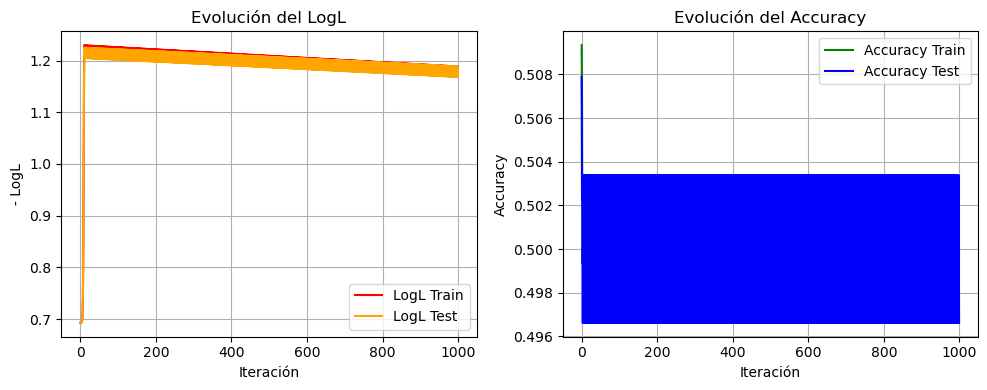

Iniciando entrenamiento con:
  - Tamaño de imagen: 64
  - Alpha: 0.0001
  - Repeticiones: 1000

Iteración 0, LogL Train: 0.6935, Accuracy Train: 0.5000 | LogL Test: 0.6937, Accuracy Test: 0.4966
Iteración 100, LogL Train: 0.6928, Accuracy Train: 0.5300 | LogL Test: 0.6928, Accuracy Test: 0.5338
Iteración 200, LogL Train: 0.6924, Accuracy Train: 0.5533 | LogL Test: 0.6925, Accuracy Test: 0.5507
Iteración 300, LogL Train: 0.6920, Accuracy Train: 0.5747 | LogL Test: 0.6921, Accuracy Test: 0.5755
Iteración 400, LogL Train: 0.6916, Accuracy Train: 0.6040 | LogL Test: 0.6917, Accuracy Test: 0.6002
Iteración 500, LogL Train: 0.6912, Accuracy Train: 0.6220 | LogL Test: 0.6914, Accuracy Test: 0.6115
Iteración 600, LogL Train: 0.6909, Accuracy Train: 0.6467 | LogL Test: 0.6910, Accuracy Test: 0.6340
Iteración 700, LogL Train: 0.6905, Accuracy Train: 0.6587 | LogL Test: 0.6907, Accuracy Test: 0.6441
Iteración 800, LogL Train: 0.6901, Accuracy Train: 0.6700 | LogL Test: 0.6903, Accuracy Test: 0.66

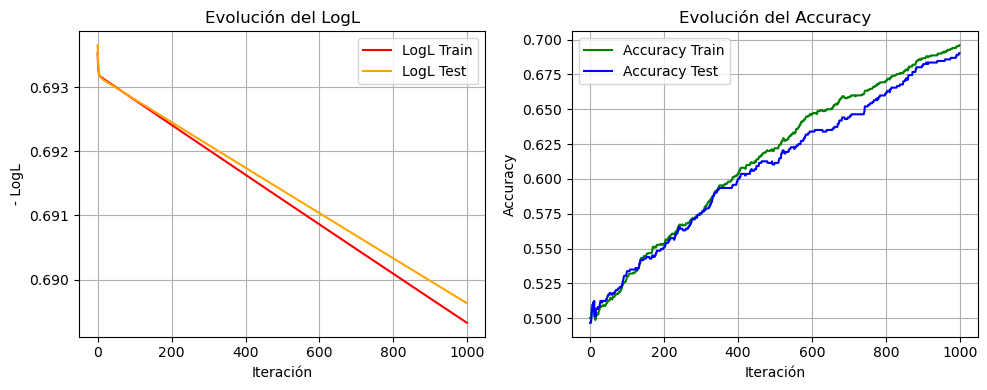

Iniciando entrenamiento con:
  - Tamaño de imagen: 64
  - Alpha: 1e-05
  - Repeticiones: 1000

Iteración 0, LogL Train: 0.6941, Accuracy Train: 0.5000 | LogL Test: 0.6936, Accuracy Test: 0.5034
Convergencia alcanzada en la iteración 83


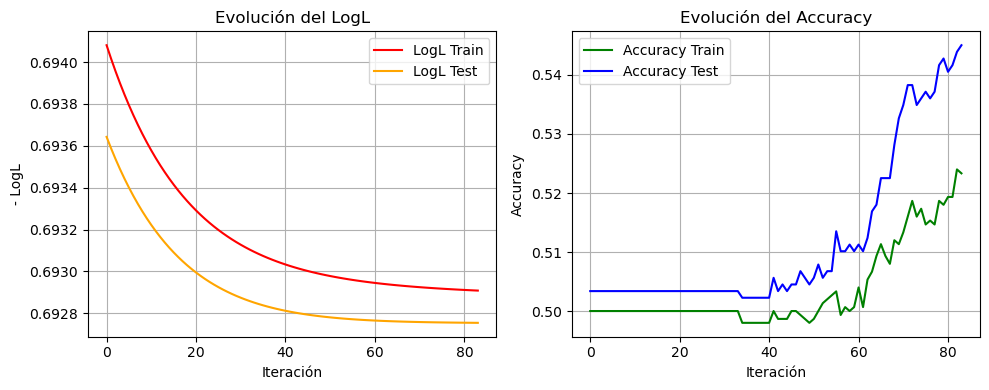

In [375]:
alphas = [0.1, 0.01, 0.001, 0.0001, 0.00001]

size = 64
repeticiones = 1000

for alpha in alphas:
    w_final, b_final, logL_train, accuracy_train, logL_test, accuracy_test = entrenamiento_ascenso_gradiente(
        X_train, y_train, X_test, y_test, size, alpha, repeticiones)
    visualizar_entrenamiento(logL_train, accuracy_train, logL_test, accuracy_test)

In [376]:
# Función de matriz de confusión (usando vectores X e y)
def matriz_confusion(X, y, w, b, umbral=0.5):
    vp = 0
    fp = 0
    vn = 0
    fn = 0

    pred = prediccion(X, y, w, b)
    clases_predichas = (pred > umbral).astype(int).flatten()

    for real, pred in zip(y, clases_predichas):
        if real == 1 and pred == 1:
            vp += 1
        elif real == 0 and pred == 1:
            fp += 1
        elif real == 0 and pred == 0:
            vn += 1
        elif real == 1 and pred == 0:
            fn += 1

    # Retornamos en orden para que coincida con la matriz visual
    return vn, fp, fn, vp

In [377]:
def graficar_matrices_confusion(matriz_train, matriz_test):
    etiquetas = ["Pred Healthy", "Pred Parkinson"]
    filas = ["True Healthy", "True Parkinson"]

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    sns.heatmap(matriz_train, annot=True, fmt="d", cmap="Greens", cbar=False,
                xticklabels=etiquetas, yticklabels=filas, ax=axes[0])
    axes[0].set_title("Train")
    axes[0].set_xlabel("")
    axes[0].set_ylabel("")

    sns.heatmap(matriz_test, annot=True, fmt="d", cmap="Greens", cbar=False,
                xticklabels=etiquetas, yticklabels=filas, ax=axes[1])
    axes[1].set_title("Test")
    axes[1].set_xlabel("")
    axes[1].set_ylabel("")

    plt.tight_layout()
    plt.show()

Iniciando entrenamiento con:
  - Tamaño de imagen: 64
  - Alpha: 0.0001
  - Repeticiones: 1000

Iteración 0, LogL Train: 0.6951, Accuracy Train: 0.5000 | LogL Test: 0.6946, Accuracy Test: 0.5034
Iteración 100, LogL Train: 0.6926, Accuracy Train: 0.5440 | LogL Test: 0.6926, Accuracy Test: 0.5518
Iteración 200, LogL Train: 0.6922, Accuracy Train: 0.5620 | LogL Test: 0.6922, Accuracy Test: 0.5664
Iteración 300, LogL Train: 0.6918, Accuracy Train: 0.5867 | LogL Test: 0.6918, Accuracy Test: 0.5777
Iteración 400, LogL Train: 0.6914, Accuracy Train: 0.6067 | LogL Test: 0.6915, Accuracy Test: 0.5957
Iteración 500, LogL Train: 0.6910, Accuracy Train: 0.6207 | LogL Test: 0.6911, Accuracy Test: 0.6070
Iteración 600, LogL Train: 0.6906, Accuracy Train: 0.6433 | LogL Test: 0.6908, Accuracy Test: 0.6216
Iteración 700, LogL Train: 0.6903, Accuracy Train: 0.6540 | LogL Test: 0.6904, Accuracy Test: 0.6329
Iteración 800, LogL Train: 0.6899, Accuracy Train: 0.6640 | LogL Test: 0.6901, Accuracy Test: 0.64

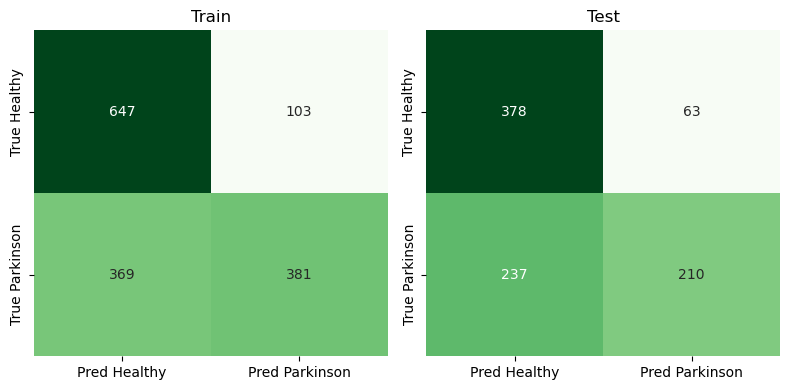

In [378]:
size = 64
alpha = 0.0001
repeticiones = 1000

w_final, b_final, logL_train, accuracy_train, logL_test, accuracy_test = entrenamiento_ascenso_gradiente(
    X_train, y_train, X_test, y_test, size, alpha, repeticiones)

vn, fp, fn, vp = matriz_confusion(X_train, y_train, w_final, b_final)
matriz_train = np.array([[vn, fp], [fn, vp]])

vn, fp, fn, vp = matriz_confusion(X_test, y_test, w_final, b_final)
matriz_test = np.array([[vn, fp], [fn, vp]])

graficar_matrices_confusion(matriz_train, matriz_test)